In [1]:
import tensorflow as tf

In [2]:
#Sizes of ANN
input_size =56
hidden_size = 40
output_size = 1

#Initilize the paras
W_hidden = tf.Variable(tf.random_normal([input_size,hidden_size],stddev=0.01))
b_hidden = tf.Variable(tf.zeros(hidden_size))
W_out = tf.Variable(tf.random_normal([hidden_size,output_size],stddev=0.01))
b_out = tf.Variable(tf.zeros(output_size))
                    
#Create the placeholder for the data and output
                    
x = tf.placeholder(tf.float32,[None,input_size])                    
y = tf.placeholder(tf.float32,[None,output_size])
                    
# Generate the flow

hidden = tf.matmul(x,W_hidden) + b_hidden
output = tf.matmul(tf.nn.relu(hidden),W_out) + b_out
error = tf.reduce_mean((output-y)**2)

In [3]:
#Feed the real data 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

#Read data
data_path = 'Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)

#Generate one_hot vectors
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

#Normalize some variables
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

# Save the last 21 days 
test_data = data[-21*24:]
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

# Hold out the last 60 days of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]
#Data
X = train_features.iloc[:].values
y_ = np.array(train_targets.iloc[:]['cnt'],ndmin=2).T
X_val = val_features.iloc[:].values
y_val = np.array(val_targets.iloc[:]['cnt'],ndmin=2).T

In [4]:
#Build the optimizer 
learning_rate = 0.01
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(error)

#Initialize
init = tf.global_variables_initializer()                    
sess = tf.Session()                    
run = sess.run(init)  

#hyperparas
data_size = len(X)
batch_size = 100
iter_per_epoch = int(max(data_size/batch_size,1))
epochs = 300
n_Iter = epochs*iter_per_epoch
import sys
losses ={'train':[],'validation':[]}
perm = np.arange(data_size)
start = 0
epoch = 1
for it in range(n_Iter):
    if start+batch_size>data_size:
        start =0
        epoch += 1
        np.random.shuffle(perm)                
    X_batch = X[perm[start:start + batch_size]]
    y_batch = y_[perm[start:start + batch_size]]            
    #Run the training
    sess.run(train_op,{x: X_batch, y: y_batch})
    
    #Output
    if start == 0:
        
        training_accuracy = sess.run(error,{x:X_batch, y: y_batch})
        vali_accuracy = sess.run(error,{x: X_val, y: y_val})
        sys.stdout.write('\r Epoch: %d... training accuracy: %f...validation accuracy: %f ' %(epoch,training_accuracy,vali_accuracy))
    start = start + batch_size
    losses['train'].append(training_accuracy)    
    losses['validation'].append(vali_accuracy)    

 Epoch: 300... training accuracy: 0.041805...validation accuracy: 0.133145 

(-0.050473021436482676, 0.5)

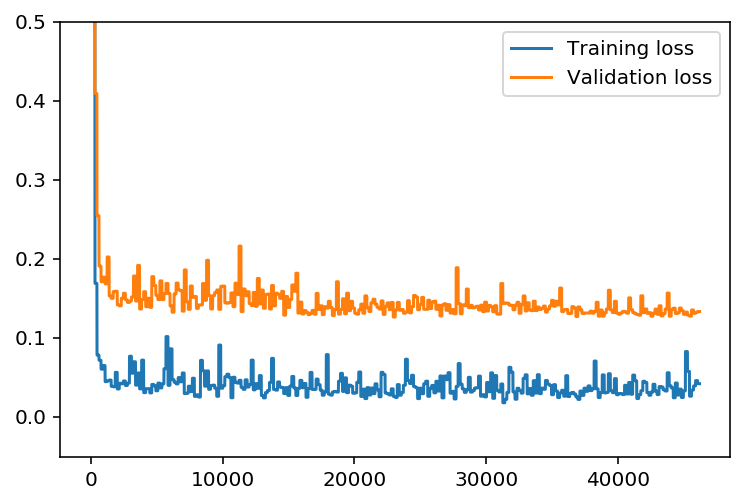

In [5]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.ylim(ymax=.5)

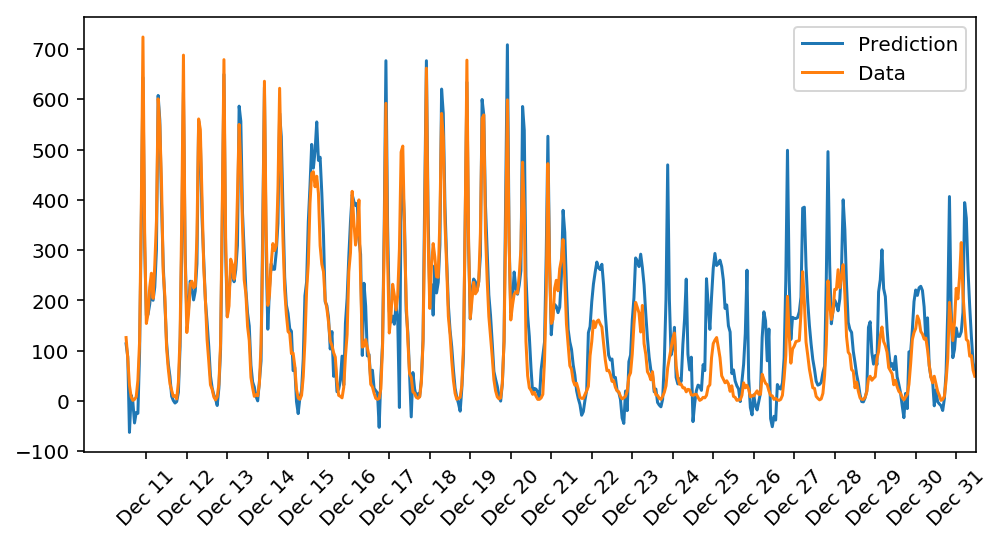

In [6]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
X_test = test_features.iloc[:].values
y_test = np.array(test_targets.iloc[:]['cnt'],ndmin=2).T

out = sess.run(output,{x: X_test})
predictions = out*std + mean

sess.close()
ax.plot(predictions, label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)